## Data Overview

In [31]:
# read all files names
import numpy as np 
import pandas as pd

import os

all_file_names = []
for dirname, _, filenames in os.walk('/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'):
    for filename in filenames:
        all_file_names.append(os.path.join(dirname, filename))

print("Number of data files", len(all_file_names))

Number of data files 253


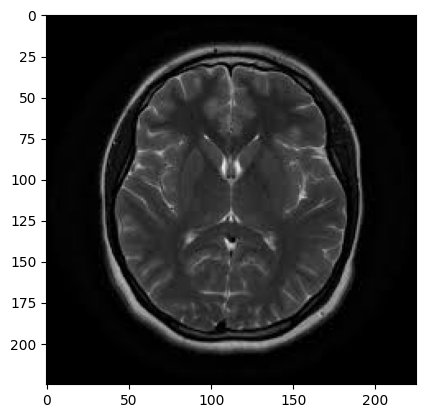

In [32]:
# Plot sample image
import cv2
import matplotlib.pyplot as plt
img = cv2.imread(all_file_names[10])
plt.imshow(img)

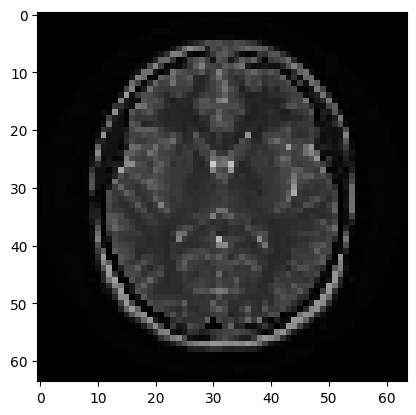

In [33]:
# Resize the image
NEW_DIM = 64, 64
resized_img = cv2.resize(img, NEW_DIM)
plt.imshow(resized_img)

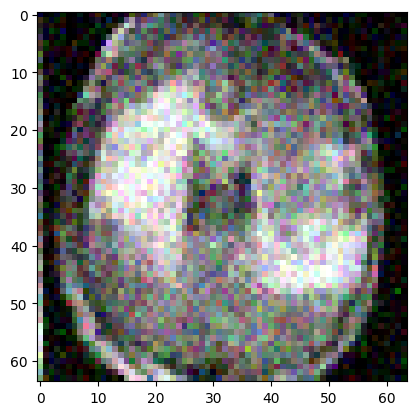

In [55]:
# noisy image
NEW_DIM = 64, 64
resized_img = cv2.resize(img, NEW_DIM)
# Define Gaussian noise
resized_img = torch.tensor(resized_img)
mean = 0.0
std = 0.1  # adjust noise strength
noise = torch.randn_like(resized_img) * std + mean
noise = noise.numpy()
resized_img = resized_img + noise

plt.imshow(resized_img)

In [34]:
# Create data loader
import torch
import torchvision.transforms as transforms
#import torchvision.utils as vutils
from torchvision import datasets
from torch.utils.data import Subset

batch_size = 64
NEW_DIM = 64, 64
datadir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'
dataset = datasets.ImageFolder(root=datadir,
                               transform=transforms.Compose([
                               transforms.Resize(NEW_DIM[0]),
                               transforms.CenterCrop(NEW_DIM[0]),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

## DCGAN model

In [35]:
"""This model is adopted from https://www.kaggle.com/code/maimunulkjisan/dcgan-in-action-generating-images"""
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d( in_ch, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
     
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
    
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
          
            nn.ConvTranspose2d( 64, num_ch, 4, 2, 1, bias=False),
            nn.Tanh())

    def forward(self, input):
        return self.main(input)



class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(num_ch, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
    
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
      
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
       
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, input):
        return self.main(input)

In [36]:
from torchinfo import summary
num_ch = 3
in_ch = 100
G = Generator()
summary(G, input_size=(1, in_ch, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 64, 64]            --
├─Sequential: 1-1                        [1, 3, 64, 64]            --
│    └─ConvTranspose2d: 2-1              [1, 512, 4, 4]            819,200
│    └─BatchNorm2d: 2-2                  [1, 512, 4, 4]            1,024
│    └─ReLU: 2-3                         [1, 512, 4, 4]            --
│    └─ConvTranspose2d: 2-4              [1, 256, 8, 8]            2,097,152
│    └─BatchNorm2d: 2-5                  [1, 256, 8, 8]            512
│    └─ReLU: 2-6                         [1, 256, 8, 8]            --
│    └─ConvTranspose2d: 2-7              [1, 128, 16, 16]          524,288
│    └─BatchNorm2d: 2-8                  [1, 128, 16, 16]          256
│    └─ReLU: 2-9                         [1, 128, 16, 16]          --
│    └─ConvTranspose2d: 2-10             [1, 64, 32, 32]           131,072
│    └─BatchNorm2d: 2-11                 [1, 64, 32, 32]  

In [38]:
from torchinfo import summary
num_ch = 3
in_ch = 100
D = Discriminator()
summary(D, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1, 1, 1]              --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           3,072
│    └─LeakyReLU: 2-2                    [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 128, 16, 16]          131,072
│    └─BatchNorm2d: 2-4                  [1, 128, 16, 16]          256
│    └─LeakyReLU: 2-5                    [1, 128, 16, 16]          --
│    └─Conv2d: 2-6                       [1, 256, 8, 8]            524,288
│    └─BatchNorm2d: 2-7                  [1, 256, 8, 8]            512
│    └─LeakyReLU: 2-8                    [1, 256, 8, 8]            --
│    └─Conv2d: 2-9                       [1, 512, 4, 4]            2,097,152
│    └─BatchNorm2d: 2-10                 [1, 512, 4, 4]            1,024
│    └─LeakyReLU: 2-11                   [1, 512, 4, 4]     

Epoch 0 , DLoss:  4.01359187066555 , GLoss:  37.810502767562866


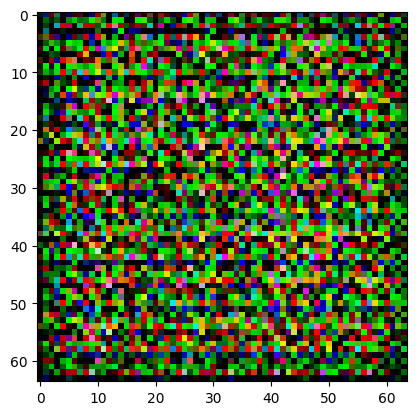

Epoch 1 , DLoss:  0.679419431835413 , GLoss:  58.02227973937988
Epoch 2 , DLoss:  0.37595436349511147 , GLoss:  65.57952642440796
Epoch 3 , DLoss:  0.2891963478177786 , GLoss:  72.59800910949707
Epoch 4 , DLoss:  0.9638266572728753 , GLoss:  97.16931676864624
Epoch 5 , DLoss:  0.46986868465319276 , GLoss:  127.33115482330322
Epoch 6 , DLoss:  4.287369620287791 , GLoss:  141.19734477996826
Epoch 7 , DLoss:  2.9484194051474333 , GLoss:  117.91689586639404
Epoch 8 , DLoss:  1.0333036473020911 , GLoss:  97.39898777008057
Epoch 9 , DLoss:  4.273484990000725 , GLoss:  71.89934206008911
Epoch 10 , DLoss:  6.896312985569239 , GLoss:  55.825079679489136
Epoch 11 , DLoss:  4.7082319259643555 , GLoss:  45.934887409210205
Epoch 12 , DLoss:  8.662536054849625 , GLoss:  47.09845781326294
Epoch 13 , DLoss:  8.594976365566254 , GLoss:  36.35188174247742
Epoch 14 , DLoss:  4.696743011474609 , GLoss:  29.28946018218994
Epoch 15 , DLoss:  6.442435145378113 , GLoss:  34.13153946399689
Epoch 16 , DLoss:  3

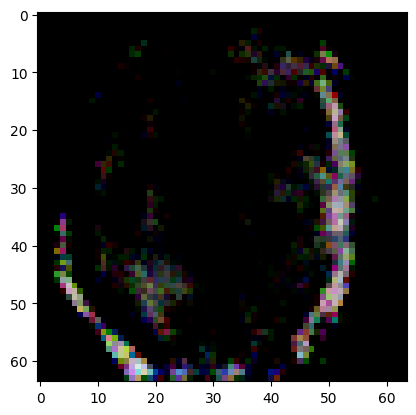

Epoch 51 , DLoss:  5.830970799550414 , GLoss:  57.4908264875412
Epoch 52 , DLoss:  2.004326805472374 , GLoss:  39.881887912750244
Epoch 53 , DLoss:  3.227263569831848 , GLoss:  49.490363121032715
Epoch 54 , DLoss:  1.8746352195739746 , GLoss:  48.71309232711792
Epoch 55 , DLoss:  1.9593561291694641 , GLoss:  49.09987783432007
Epoch 56 , DLoss:  2.367823913693428 , GLoss:  50.304007053375244
Epoch 57 , DLoss:  1.5342132300138474 , GLoss:  38.98629879951477
Epoch 58 , DLoss:  10.396604478359222 , GLoss:  66.68158268928528
Epoch 59 , DLoss:  2.1918817311525345 , GLoss:  42.49001932144165
Epoch 60 , DLoss:  1.9865381568670273 , GLoss:  42.83854866027832
Epoch 61 , DLoss:  3.2544338516891003 , GLoss:  53.41744017601013
Epoch 62 , DLoss:  2.173607259988785 , GLoss:  43.263572692871094
Epoch 63 , DLoss:  2.2009931951761246 , GLoss:  43.60033893585205
Epoch 64 , DLoss:  2.845840871334076 , GLoss:  45.129703760147095
Epoch 65 , DLoss:  1.31167296692729 , GLoss:  42.78373432159424
Epoch 66 , DLo

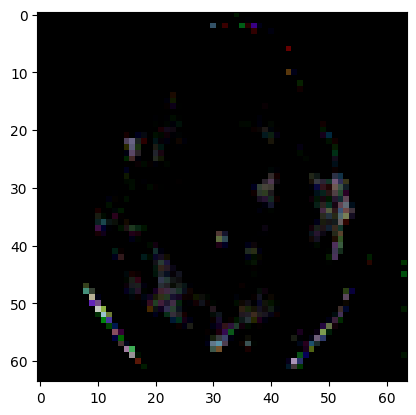

Epoch 101 , DLoss:  2.7349403724074364 , GLoss:  50.387264013290405
Epoch 102 , DLoss:  2.5134351402521133 , GLoss:  49.012420654296875
Epoch 103 , DLoss:  1.62533850222826 , GLoss:  43.41951012611389
Epoch 104 , DLoss:  1.3740195408463478 , GLoss:  36.066017150878906
Epoch 105 , DLoss:  1.53891259431839 , GLoss:  40.95717263221741
Epoch 106 , DLoss:  8.047889351844788 , GLoss:  54.040377616882324
Epoch 107 , DLoss:  3.4369092881679535 , GLoss:  49.74727010726929
Epoch 108 , DLoss:  2.307138681411743 , GLoss:  43.03396701812744
Epoch 109 , DLoss:  1.959825113415718 , GLoss:  38.08027911186218
Epoch 110 , DLoss:  4.560658611357212 , GLoss:  46.47065234184265
Epoch 111 , DLoss:  1.9552590548992157 , GLoss:  45.36646270751953
Epoch 112 , DLoss:  1.346611961722374 , GLoss:  38.11695861816406
Epoch 113 , DLoss:  1.5506786778569221 , GLoss:  35.359710931777954
Epoch 114 , DLoss:  1.893005944788456 , GLoss:  38.49738955497742
Epoch 115 , DLoss:  1.7722267508506775 , GLoss:  43.926669120788574

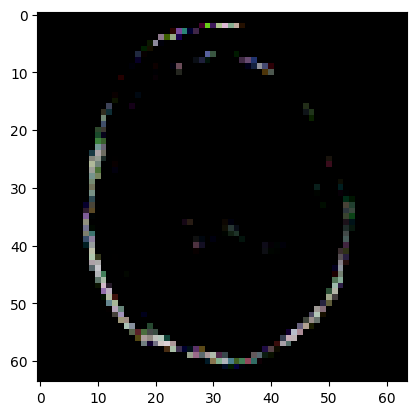

Epoch 151 , DLoss:  0.8565631061792374 , GLoss:  39.09538173675537
Epoch 152 , DLoss:  1.4209407269954681 , GLoss:  43.99360179901123
Epoch 153 , DLoss:  6.226253733038902 , GLoss:  68.10293817520142
Epoch 154 , DLoss:  1.4728312194347382 , GLoss:  40.77733325958252
Epoch 155 , DLoss:  1.1652962639927864 , GLoss:  41.03386163711548
Epoch 156 , DLoss:  1.24204583466053 , GLoss:  46.70064997673035
Epoch 157 , DLoss:  0.9813138172030449 , GLoss:  41.63487362861633
Epoch 158 , DLoss:  0.8391167148947716 , GLoss:  43.57838439941406
Epoch 159 , DLoss:  1.0252331867814064 , GLoss:  38.00008726119995
Epoch 160 , DLoss:  0.835977278649807 , GLoss:  37.51132369041443
Epoch 161 , DLoss:  0.8574472963809967 , GLoss:  38.79553174972534
Epoch 162 , DLoss:  0.9056905284523964 , GLoss:  37.14900231361389
Epoch 163 , DLoss:  0.7403797879815102 , GLoss:  39.6345591545105
Epoch 164 , DLoss:  0.9785231947898865 , GLoss:  42.902098417282104
Epoch 165 , DLoss:  0.8997991271317005 , GLoss:  38.44882917404175

In [39]:
"""Training Loop for CNN based GAN"""
num_ch = 3
in_ch = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_func = nn.BCELoss()
G = Generator().to(device)
D = Discriminator().to(device)
optimizerD = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))

sample_noise = torch.randn(64, in_ch, 1, 1, device=device)

G_losses = []
D_losses = []
num_epochs = 200
for epoch in range(num_epochs):
    G_losses = 0
    D_losses = 0
    for data in dataloader:
        real_label = 1.0
        fake_label = 0.0
        
        D.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = D(real_cpu).view(-1)
        errD_real = loss_func(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, in_ch, 1, 1, device=device)
        fake = G(noise)
        label.fill_(fake_label)
        output = D(fake.detach()).view(-1)
        errD_fake = loss_func(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        G.zero_grad()
        label.fill_(real_label)
        output = D(fake).view(-1)
        errG = loss_func(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
                
        G_losses += (errG.item())
        D_losses += (errD.item())

    print("Epoch", epoch, ", DLoss: ", D_losses, ", GLoss: ", G_losses)
    if epoch%50 == 0:
        with torch.no_grad():
            fake = G(sample_noise).detach().cpu()
        img = fake[0].cpu().permute(1, 2, 0).numpy()
        #img = (img - img.min())/(img.max() - img.min())
        plt.imshow(img)
        plt.show()

## Visualization

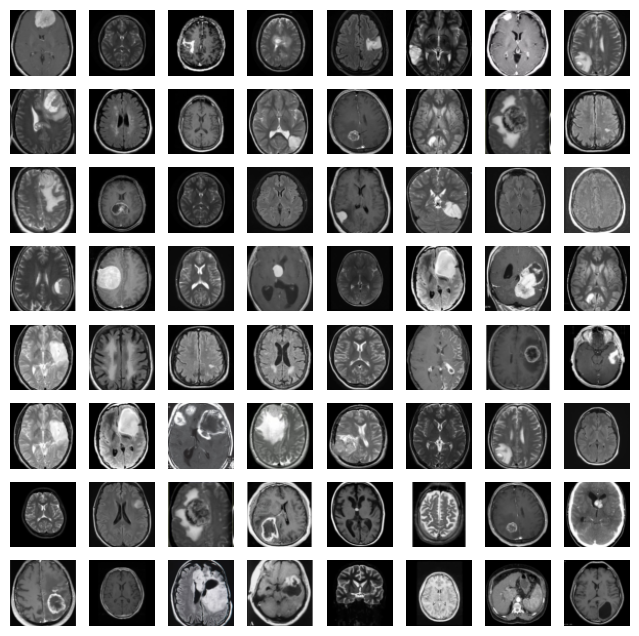

In [40]:
# Show random Real images and make a list of real images to be used for PCA visulization
batch1 = next(iter(dataloader))
batch2 = next(iter(dataloader))
batch3 = next(iter(dataloader))

fig, axes = plt.subplots(8, 8, figsize=(8, 8))

real_images_scaled = []
for i, ax in enumerate(axes.flat):
    img = batch1[0][i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    real_images_scaled.append(img)
    ax.imshow(img)
    ax.axis("off")

for i in range(64):
    img = batch2[0][i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    real_images_scaled.append(img)

for i in range(64):
    img = batch3[0][i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    real_images_scaled.append(img)

fig.savefig("real_images.pdf", bbox_inches='tight')
plt.show()

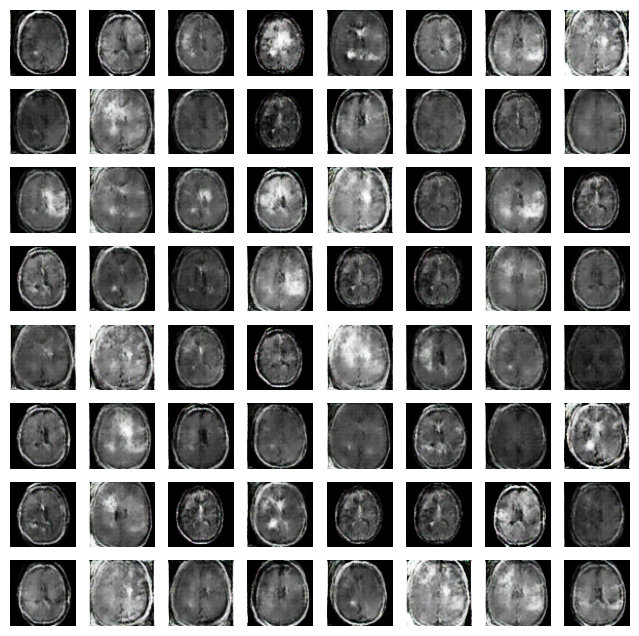

In [41]:
# fake images at inference from random sampling and make a list of fake images
fixed_noise = torch.randn(64, in_ch, 1, 1, device=device)
with torch.no_grad():
    fake_images = G(fixed_noise).detach().cpu()

fig, axes = plt.subplots(8, 8, figsize=(8, 8))

fake_images_scaled = []
for i, ax in enumerate(axes.flat):
    img = fake_images[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    fake_images_scaled.append(img)
    ax.imshow(img)
    ax.axis("off")

fixed_noise = torch.randn(64, in_ch, 1, 1, device=device)
with torch.no_grad():
    fake_images = G(fixed_noise).detach().cpu()
for i in range(64):
    img = fake_images[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    fake_images_scaled.append(img)

fixed_noise = torch.randn(64, in_ch, 1, 1, device=device)
with torch.no_grad():
    fake_images = G(fixed_noise).detach().cpu()
for i in range(64):
    img = fake_images[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    fake_images_scaled.append(img)
fig.savefig("model_1_images.pdf", bbox_inches='tight')
plt.show()

In [42]:
# measure similairty between images
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

import torch
import torch.nn as nn
from torchvision.models import vgg16
from torchvision import transforms
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity


class ImageSimilarity:
    def __init__(self, device="cpu"):
        self.device = device

        # Pretrained VGG16 for perceptual similarity (deep features)
        self.vgg = vgg16(pretrained=True).features[:16]  # conv3 layer
        self.vgg.eval().to(self.device)

        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    def _preprocess(self, img_np):
        """Convert numpy array (H,W,C) -> tensor for VGG."""
        if img_np.min() < 0:  # rescale if in [-1,1]
            img_np = ((img_np + 1) * 127.5).astype(np.uint8)
        else:
            img_np = img_np.astype(np.uint8)

        img = Image.fromarray(img_np)
        return self.transform(img).unsqueeze(0).to(self.device)

    def mse(self, img1, img2):
        """Mean Squared Error (lower = more similar)."""
        return mean_squared_error(img1, img2)

    def psnr(self, img1, img2):
        """Peak Signal-to-Noise Ratio (higher = better)."""
        return peak_signal_noise_ratio(img1, img2, data_range=img1.max() - img1.min())

    def ssim_score(self, img1, img2):
        """Structural Similarity Index (higher = more similar)."""
        if img1.ndim == 3 and img1.shape[2] == 3:
            img1 = np.mean(img1, axis=2)
            img2 = np.mean(img2, axis=2)
        return ssim(img1, img2, data_range=img1.max() - img1.min(), multichannel=True)

    def perceptual_similarity(self, img1, img2):
        """Perceptual similarity via VGG features + cosine similarity."""
        t1 = img1
        t2 = img2

        with torch.no_grad():
            f1 = self.vgg(t1).flatten().cpu().numpy().reshape(1, -1)
            f2 = self.vgg(t2).flatten().cpu().numpy().reshape(1, -1)

        return cosine_similarity(f1, f2)[0, 0]

    def compare(self, img1, img2):
        """Return multiple similarity metrics."""
        return {
            "MSE": self.mse(img1, img2),
            "PSNR": self.psnr(img1, img2),
            "SSIM": self.ssim_score(img1, img2),
            #"Perceptual (VGG Cosine)": self.perceptual_similarity(img1, img2)
        }

In [43]:
from tqdm import tqdm
fake_images_scaled = np.array(fake_images_scaled)
real_images_scaled = np.array(real_images_scaled)

compare = ImageSimilarity()

psnr_count = []
for fake_img in tqdm(fake_images_scaled):
    for real_img in real_images_scaled:
        psnr_count.append(compare.psnr(real_img, fake_img))

mse_count = []
for fake_img in tqdm(fake_images_scaled):
    for real_img in real_images_scaled:
        mse_count.append(compare.mse(real_img, fake_img))

ssim_score_count = []
for fake_img in tqdm(fake_images_scaled):
    for real_img in real_images_scaled:
        ssim_score_count.append(compare.ssim_score(real_img, fake_img))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 192/192 [00:24<00:00,  7.76it/s]


In [44]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hist(data, what2plot="count"):

    # Plot histogram
    plt.figure(figsize=(8,6))
    plt.hist(data, bins=6, alpha=0.7, color='skyblue', edgecolor='black')
    
    # Increase font sizes
    plt.xlabel(what2plot, fontsize=16)         # x-axis label
    plt.ylabel('Frequency', fontsize=16)     # y-axis label
    plt.xticks(fontsize=14)                  # x-axis ticks
    plt.yticks(fontsize=14)                  # y-axis ticks
    plt.grid(axis='y', alpha=0.75)
    
    # Save as PDF
    plt.savefig(what2plot+'histogram.pdf', format='pdf')
    
    plt.show()

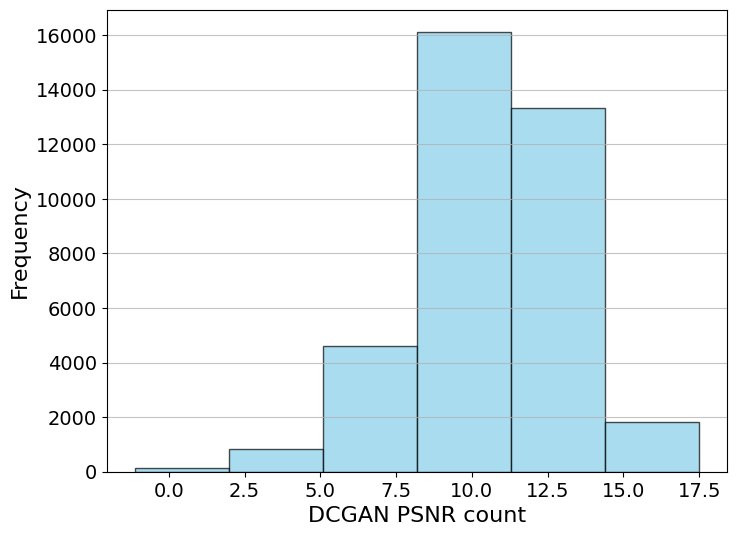

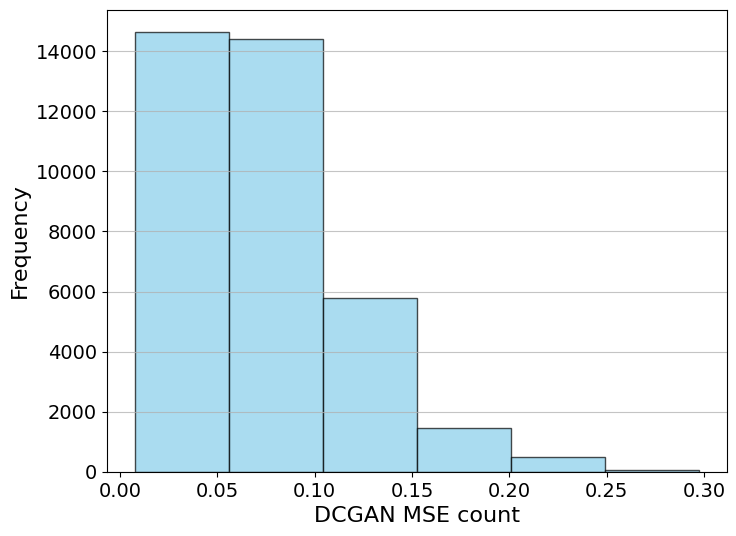

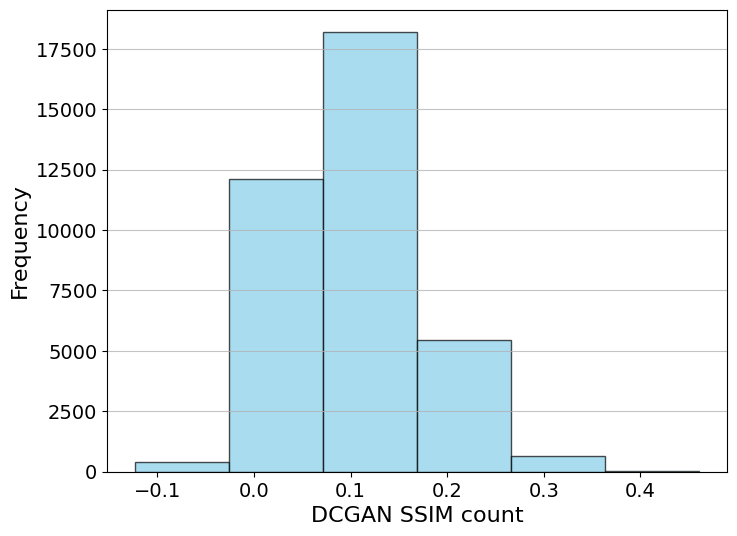

In [45]:
import matplotlib.pyplot as plt

plot_hist(psnr_count, what2plot="DCGAN PSNR count")
plot_hist(mse_count, what2plot="DCGAN MSE count")
plot_hist(ssim_score_count, what2plot="DCGAN SSIM count")

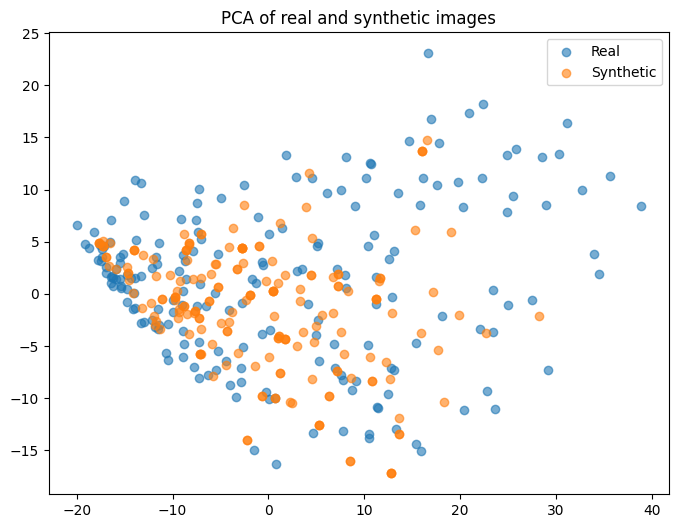

In [46]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

fake_images_scaled = np.array(fake_images_scaled)
real_images_scaled = np.array(real_images_scaled)
fake_images_scaled = fake_images_scaled.reshape(fake_images_scaled.shape[0], -1)
real_images_scaled = real_images_scaled.reshape(real_images_scaled.shape[0], -1)
X = np.vstack((fake_images_scaled, real_images_scaled))
y = np.array([0]*len(fake_images_scaled) + [1]*len(real_images_scaled))  # labels: 0=A, 1=B

pca = PCA(n_components=2)
X_embedded = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_embedded[y==0, 0], X_embedded[y==0, 1], label="Real", alpha=0.6)
plt.scatter(X_embedded[y==1, 0], X_embedded[y==1, 1], label="Synthetic", alpha=0.6)
plt.legend()
plt.title("PCA of real and synthetic images")
plt.savefig("model_1_pca.pdf", bbox_inches='tight')
plt.show()

## Pix2Pix Model

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from PIL import Image
import os


class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, in_channels=6):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [48]:
from torchinfo import summary

G = UNetGenerator()
summary(G, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
UNetGenerator                            [1, 3, 64, 64]            --
├─Sequential: 1-1                        [1, 256, 8, 8]            --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           3,136
│    └─LeakyReLU: 2-2                    [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 128, 16, 16]          131,200
│    └─BatchNorm2d: 2-4                  [1, 128, 16, 16]          256
│    └─LeakyReLU: 2-5                    [1, 128, 16, 16]          --
│    └─Conv2d: 2-6                       [1, 256, 8, 8]            524,544
│    └─BatchNorm2d: 2-7                  [1, 256, 8, 8]            512
│    └─LeakyReLU: 2-8                    [1, 256, 8, 8]            --
├─Sequential: 1-2                        [1, 3, 64, 64]            --
│    └─ConvTranspose2d: 2-9              [1, 128, 16, 16]          524,416
│    └─BatchNorm2d: 2-10                 [1, 128, 16, 16]        

In [50]:
from torchinfo import summary

D = Discriminator()
summary(D, input_size=(1, 6, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1, 7, 7]              --
├─Sequential: 1-1                        [1, 1, 7, 7]              --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           6,208
│    └─LeakyReLU: 2-2                    [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 128, 16, 16]          131,200
│    └─BatchNorm2d: 2-4                  [1, 128, 16, 16]          256
│    └─LeakyReLU: 2-5                    [1, 128, 16, 16]          --
│    └─Conv2d: 2-6                       [1, 256, 8, 8]            524,544
│    └─BatchNorm2d: 2-7                  [1, 256, 8, 8]            512
│    └─LeakyReLU: 2-8                    [1, 256, 8, 8]            --
│    └─Conv2d: 2-9                       [1, 1, 7, 7]              4,097
│    └─Sigmoid: 2-10                     [1, 1, 7, 7]              --
Total params: 666,817
Trainable params: 666,817
Non-trainable param

Epoch [1/200] | Loss_D: 0.4167 | Loss_G: 37.6023


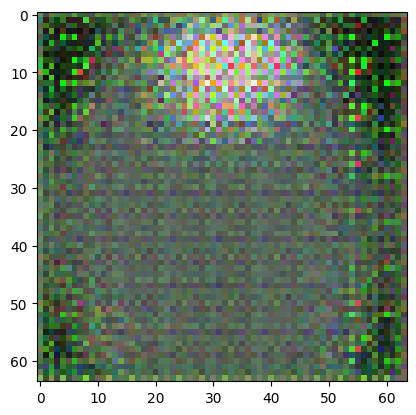

Epoch [2/200] | Loss_D: 0.2756 | Loss_G: 26.9456
Epoch [3/200] | Loss_D: 0.3293 | Loss_G: 21.3856
Epoch [4/200] | Loss_D: 0.3634 | Loss_G: 19.8854
Epoch [5/200] | Loss_D: 0.3615 | Loss_G: 17.4259
Epoch [6/200] | Loss_D: 0.4256 | Loss_G: 16.6708
Epoch [7/200] | Loss_D: 0.3384 | Loss_G: 15.0856
Epoch [8/200] | Loss_D: 0.2875 | Loss_G: 15.2047
Epoch [9/200] | Loss_D: 0.2699 | Loss_G: 14.6056
Epoch [10/200] | Loss_D: 0.1990 | Loss_G: 14.0916
Epoch [11/200] | Loss_D: 0.2087 | Loss_G: 14.1057
Epoch [12/200] | Loss_D: 0.1535 | Loss_G: 14.1519
Epoch [13/200] | Loss_D: 0.1231 | Loss_G: 13.6138
Epoch [14/200] | Loss_D: 0.2497 | Loss_G: 13.1153
Epoch [15/200] | Loss_D: 0.8752 | Loss_G: 11.9132
Epoch [16/200] | Loss_D: 0.4693 | Loss_G: 11.2300
Epoch [17/200] | Loss_D: 0.2732 | Loss_G: 11.6092
Epoch [18/200] | Loss_D: 0.3318 | Loss_G: 11.7343
Epoch [19/200] | Loss_D: 0.2831 | Loss_G: 12.6798
Epoch [20/200] | Loss_D: 0.1921 | Loss_G: 11.7432
Epoch [21/200] | Loss_D: 0.0399 | Loss_G: 15.7695
Epoch [2

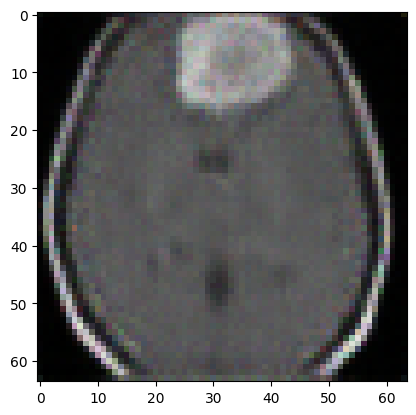

Epoch [52/200] | Loss_D: 1.0338 | Loss_G: 7.8908
Epoch [53/200] | Loss_D: 0.3587 | Loss_G: 11.0045
Epoch [54/200] | Loss_D: 0.4363 | Loss_G: 8.8988
Epoch [55/200] | Loss_D: 0.4298 | Loss_G: 9.7354
Epoch [56/200] | Loss_D: 0.3978 | Loss_G: 8.4923
Epoch [57/200] | Loss_D: 0.6925 | Loss_G: 8.8421
Epoch [58/200] | Loss_D: 0.2249 | Loss_G: 9.6984
Epoch [59/200] | Loss_D: 0.4918 | Loss_G: 8.0962
Epoch [60/200] | Loss_D: 0.2792 | Loss_G: 8.6981
Epoch [61/200] | Loss_D: 0.3975 | Loss_G: 10.9108
Epoch [62/200] | Loss_D: 0.0591 | Loss_G: 13.4356
Epoch [63/200] | Loss_D: 0.1135 | Loss_G: 11.3676
Epoch [64/200] | Loss_D: 0.0880 | Loss_G: 9.2343
Epoch [65/200] | Loss_D: 0.0915 | Loss_G: 10.0237
Epoch [66/200] | Loss_D: 0.0270 | Loss_G: 11.1107
Epoch [67/200] | Loss_D: 0.0777 | Loss_G: 10.5769
Epoch [68/200] | Loss_D: 0.0515 | Loss_G: 10.4129
Epoch [69/200] | Loss_D: 0.0773 | Loss_G: 10.2677
Epoch [70/200] | Loss_D: 0.0423 | Loss_G: 15.1646
Epoch [71/200] | Loss_D: 0.5519 | Loss_G: 9.5577
Epoch [72/

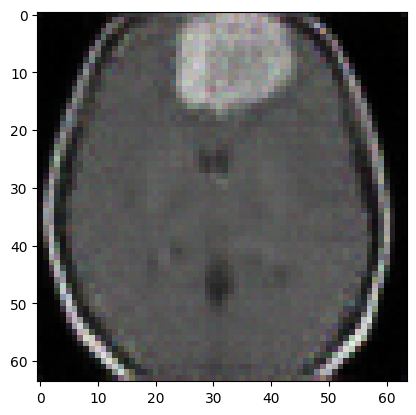

Epoch [102/200] | Loss_D: 0.5037 | Loss_G: 9.0551
Epoch [103/200] | Loss_D: 0.1584 | Loss_G: 7.5602
Epoch [104/200] | Loss_D: 0.0651 | Loss_G: 9.1951
Epoch [105/200] | Loss_D: 0.0266 | Loss_G: 10.9104
Epoch [106/200] | Loss_D: 0.0584 | Loss_G: 12.3205
Epoch [107/200] | Loss_D: 0.0108 | Loss_G: 10.9974
Epoch [108/200] | Loss_D: 0.0643 | Loss_G: 8.1830
Epoch [109/200] | Loss_D: 0.0207 | Loss_G: 11.7088
Epoch [110/200] | Loss_D: 0.0601 | Loss_G: 11.8043
Epoch [111/200] | Loss_D: 0.2897 | Loss_G: 7.2304
Epoch [112/200] | Loss_D: 0.1805 | Loss_G: 8.4301
Epoch [113/200] | Loss_D: 0.0865 | Loss_G: 11.7343
Epoch [114/200] | Loss_D: 0.0390 | Loss_G: 12.6915
Epoch [115/200] | Loss_D: 0.2525 | Loss_G: 8.4123
Epoch [116/200] | Loss_D: 0.1814 | Loss_G: 9.0558
Epoch [117/200] | Loss_D: 0.0090 | Loss_G: 11.9801
Epoch [118/200] | Loss_D: 0.0616 | Loss_G: 8.5534
Epoch [119/200] | Loss_D: 0.0079 | Loss_G: 15.8205
Epoch [120/200] | Loss_D: 0.0292 | Loss_G: 10.0025
Epoch [121/200] | Loss_D: 0.0315 | Loss_

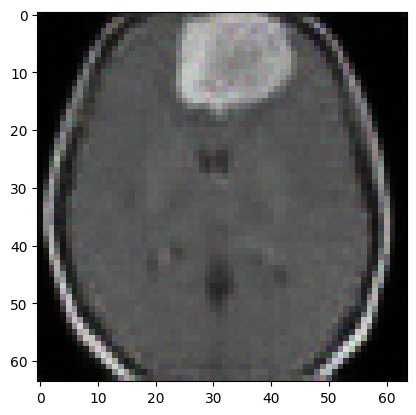

Epoch [152/200] | Loss_D: 0.0103 | Loss_G: 12.6582
Epoch [153/200] | Loss_D: 0.0132 | Loss_G: 10.3917
Epoch [154/200] | Loss_D: 0.0130 | Loss_G: 9.9701
Epoch [155/200] | Loss_D: 0.0970 | Loss_G: 8.3776
Epoch [156/200] | Loss_D: 0.0139 | Loss_G: 11.2247
Epoch [157/200] | Loss_D: 0.6158 | Loss_G: 11.1634
Epoch [158/200] | Loss_D: 0.0256 | Loss_G: 10.2880
Epoch [159/200] | Loss_D: 0.1124 | Loss_G: 13.1621
Epoch [160/200] | Loss_D: 0.0485 | Loss_G: 11.4664
Epoch [161/200] | Loss_D: 0.0072 | Loss_G: 12.7044
Epoch [162/200] | Loss_D: 1.0595 | Loss_G: 10.9983
Epoch [163/200] | Loss_D: 0.1929 | Loss_G: 13.3896
Epoch [164/200] | Loss_D: 0.0182 | Loss_G: 12.3145
Epoch [165/200] | Loss_D: 0.0138 | Loss_G: 10.3229
Epoch [166/200] | Loss_D: 0.0334 | Loss_G: 9.1139
Epoch [167/200] | Loss_D: 0.0187 | Loss_G: 9.6879
Epoch [168/200] | Loss_D: 0.0912 | Loss_G: 8.1097
Epoch [169/200] | Loss_D: 0.0336 | Loss_G: 14.7947
Epoch [170/200] | Loss_D: 1.5295 | Loss_G: 11.4657
Epoch [171/200] | Loss_D: 0.0708 | L

In [56]:
# training Pix2pix model
device = "cuda" if torch.cuda.is_available() else "cpu"

G = UNetGenerator().to(device)
D = Discriminator().to(device)

criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()

optimizer_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

num_epochs = 200
for epoch in range(num_epochs):
    for i, (input_img, _) in enumerate(dataloader):
        target_img = input_img
        input_img = input_img.to(device) 
        target_img = target_img.to(device)

        # Add noise to input
        mean = 0.0
        std = 0.1  # adjust noise strength
        noise = torch.randn_like(input_img) * std + mean
        input_img = input_img + noise

        # Train Discriminator
        optimizer_D.zero_grad()

        fake_img = G(input_img)
        D_real = D(torch.cat([input_img, target_img], dim=1))
        D_fake = D(torch.cat([input_img, fake_img.detach()], dim=1))

        real_labels = torch.ones_like(D_real, device=device)
        fake_labels = torch.zeros_like(D_fake, device=device)

        loss_D = (criterion_GAN(D_real, real_labels) + criterion_GAN(D_fake, fake_labels)) * 0.5
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        D_fake = D(torch.cat([input_img, fake_img], dim=1))
        loss_G = criterion_GAN(D_fake, real_labels) + 100 * criterion_L1(fake_img, target_img)
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss_D: {loss_D.item():.4f} | Loss_G: {loss_G.item():.4f}")
    if epoch%50 == 0:
        x = batch1[0]
        with torch.no_grad():
            fake = G(x).detach().cpu()
        img = fake[0].cpu().permute(1, 2, 0).numpy()
        img = (img + 1) / 2.0
        plt.imshow(img)
        plt.show()

### Visualization

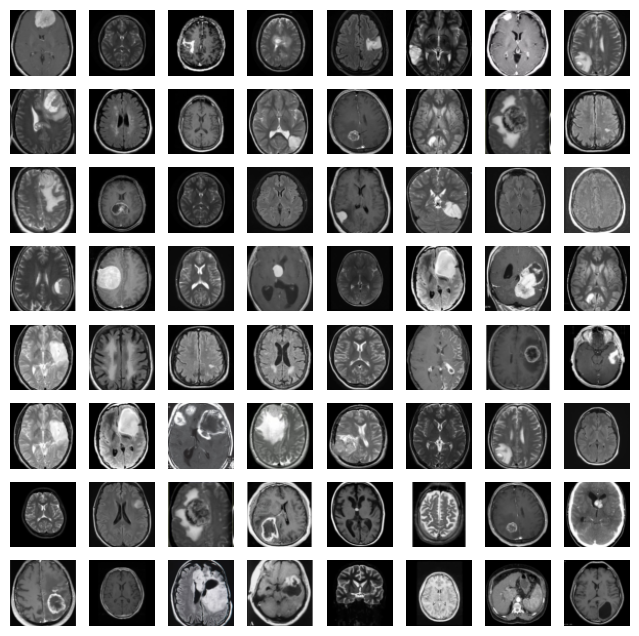

In [95]:
# Real images
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
real_images_scaled = []
for i, ax in enumerate(axes.flat):
    img = batch1[0][i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    real_images_scaled.append(img)
    ax.imshow(img)
    ax.axis("off")
fig.savefig("model_2_images.pdf", bbox_inches='tight')
plt.show()
for i in range(64):
    img = batch2[0][i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    real_images_scaled.append(img)

for i in range(64):
    img = batch3[0][i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    real_images_scaled.append(img)

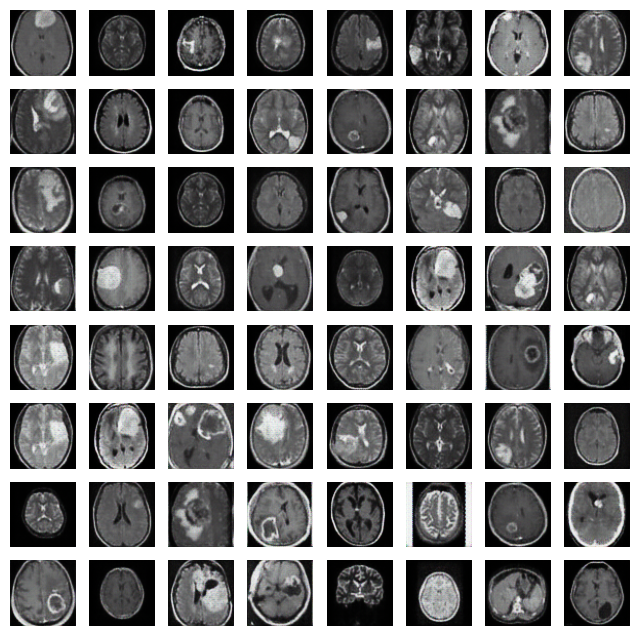

In [84]:
# inference with input images
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fake_images_scaled = []
with torch.no_grad():
    fake_images = G(batch1[0]).detach().cpu()
for i, ax in enumerate(axes.flat):
    img = fake_images[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    fake_images_scaled.append(img)
    ax.imshow(img)
    ax.axis("off")
fig.savefig("model_2_fake_images.pdf", bbox_inches='tight')
plt.show()

with torch.no_grad():
    fake_images = G(batch2[0]).detach().cpu()
for i in range(64):
    img = fake_images[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    fake_images_scaled.append(img)
    
with torch.no_grad():
    fake_images = G(batch3[0]).detach().cpu()
for i in range(64):
    img = fake_images[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    fake_images_scaled.append(img)

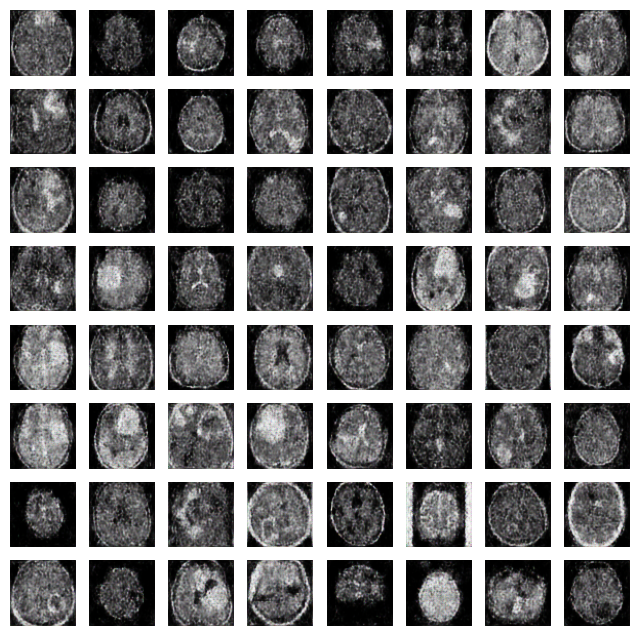

In [96]:
# inference with noisy images
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fake_images_scaled = []
with torch.no_grad():
    # Add noise to input
    input_images = batch1[0]
    mean = 0.0
    std = 1  # adjust noise strength
    noise = torch.randn_like(input_images) * std + mean
    input_images = input_images + noise
    
    fake_images = G(input_images).detach().cpu()
for i, ax in enumerate(axes.flat):
    img = fake_images[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    fake_images_scaled.append(img)
    ax.imshow(img)
    ax.axis("off")
fig.savefig("model_2_fake_noisy_images.pdf", bbox_inches='tight')
plt.show()

with torch.no_grad():
    input_images = batch2[0]
    
    mean = 0.0
    std = 1  # adjust noise strength
    noise = torch.randn_like(input_images) * std + mean
    input_images = input_images + noise
    
    fake_images = G(input_images).detach().cpu()
for i in range(64):
    img = fake_images[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    fake_images_scaled.append(img)
    
with torch.no_grad():
    input_images = batch3[0]
    
    mean = 0.0
    std = 1 # adjust noise strength
    noise = torch.randn_like(input_images) * std + mean
    input_images = input_images + noise
    
    fake_images = G(input_images).detach().cpu()
    
for i in range(64):
    img = fake_images[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    fake_images_scaled.append(img)

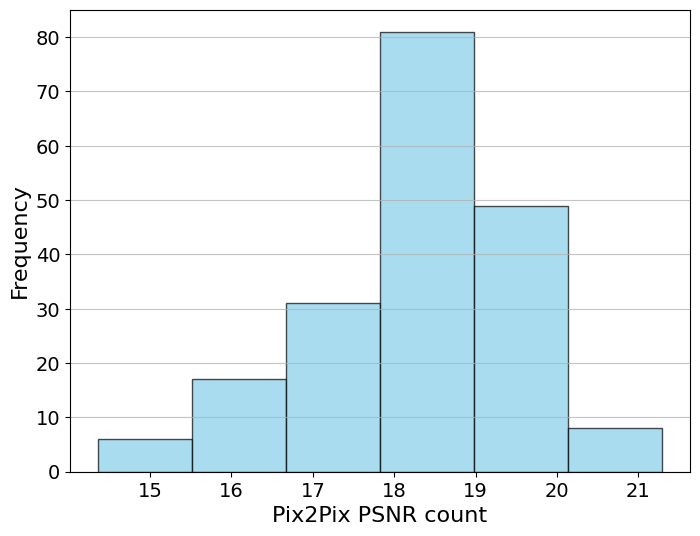

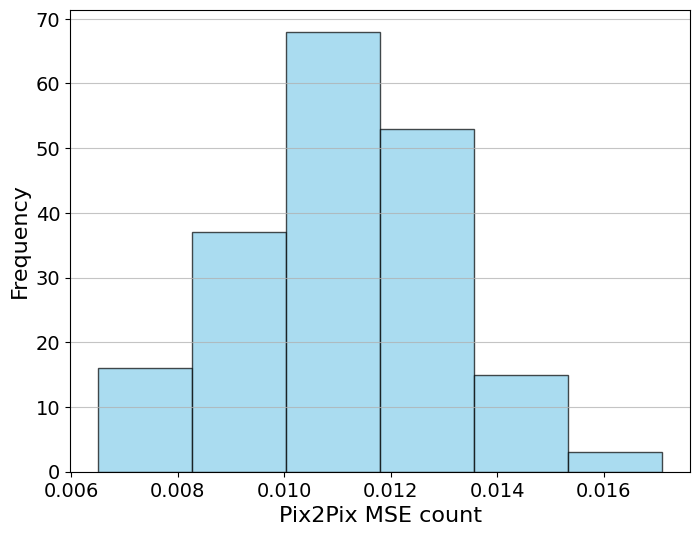

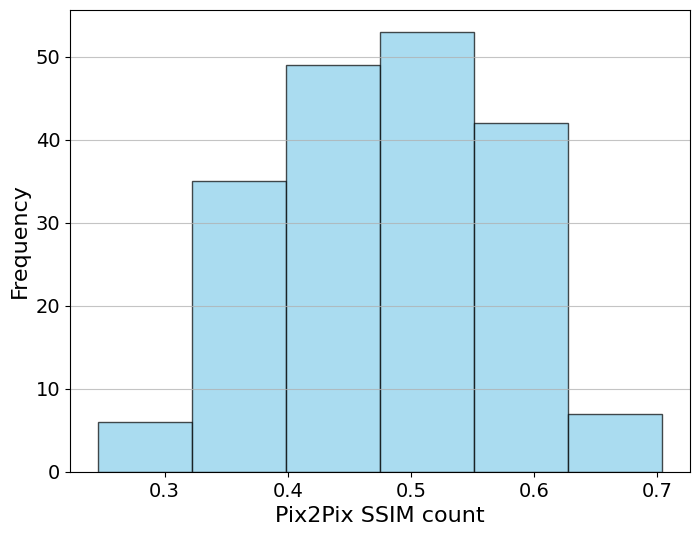

In [97]:
from tqdm import tqdm
fake_images_scaled = np.array(fake_images_scaled)
real_images_scaled = np.array(real_images_scaled)

compare = ImageSimilarity()

psnr_count = []
for fake_img, real_img in zip(fake_images_scaled, real_images_scaled):
    psnr_count.append(compare.psnr(real_img, fake_img))

mse_count = []
for fake_img, real_img in zip(fake_images_scaled, real_images_scaled):
    mse_count.append(compare.mse(real_img, fake_img))

ssim_score_count = []
for fake_img, real_img in zip(fake_images_scaled, real_images_scaled):
    ssim_score_count.append(compare.ssim_score(real_img, fake_img))

import matplotlib.pyplot as plt

plot_hist(psnr_count, what2plot="Pix2Pix PSNR count")
plot_hist(mse_count, what2plot="Pix2Pix MSE count")
plot_hist(ssim_score_count, what2plot="Pix2Pix SSIM count")

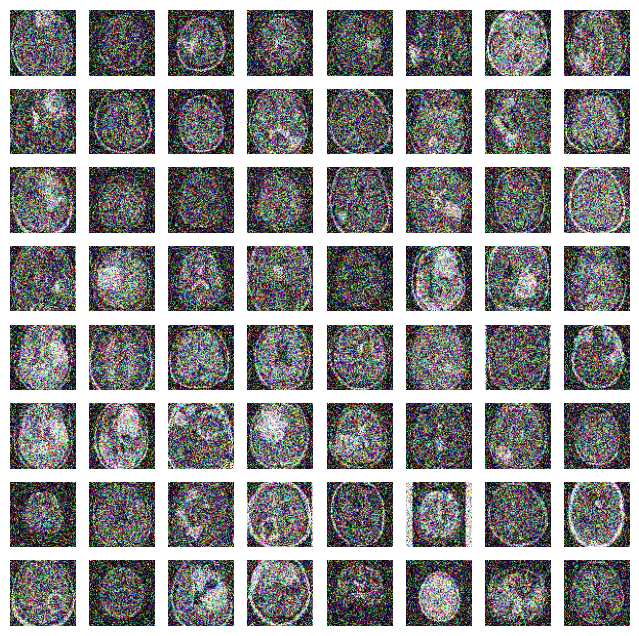

In [91]:
# noisy images as input to pix2pix
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
real_images_noisy_scaled = []
input_images = batch1[0]
mean = 0.0
std = 1  # adjust noise strength
noise = torch.randn_like(input_images) * std + mean
input_images = input_images + noise
for i, ax in enumerate(axes.flat):
    img = input_images[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    real_images_noisy_scaled.append(img)
    ax.imshow(img)
    ax.axis("off")
fig.savefig("model_2_noisy_images.pdf", bbox_inches='tight')
plt.show()

input_images = batch2[0]
mean = 0.0
std = 1  # adjust noise strength
noise = torch.randn_like(input_images) * std + mean
input_images = input_images + noise
for i in range(64):
    img = input_images[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    real_images_noisy_scaled.append(img)

input_images = batch3[0]
mean = 0.0
std = 1  # adjust noise strength
noise = torch.randn_like(input_images) * std + mean
input_images = input_images + noise
for i in range(64):
    img = input_images[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    real_images_noisy_scaled.append(img)

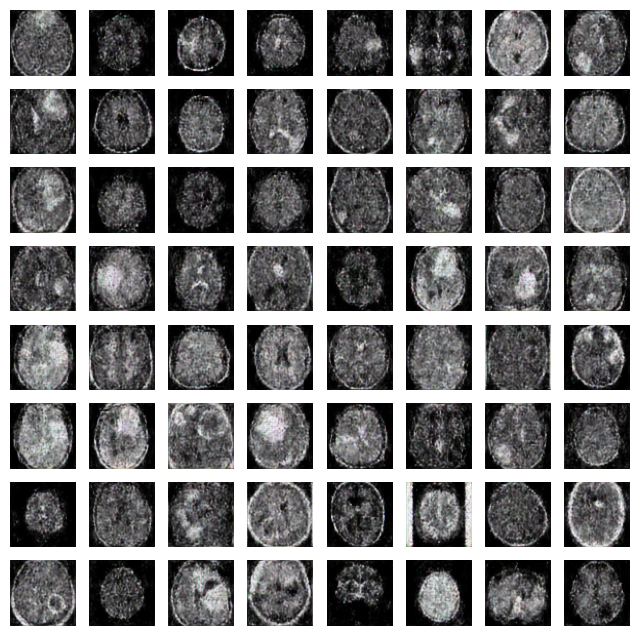

In [87]:
# inference with noisy images
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fake_images_scaled = []
with torch.no_grad():
    # Add noise to input
    input_images = batch1[0]
    mean = 0.0
    std = 1  # adjust noise strength
    noise = torch.randn_like(input_images) * std + mean
    input_images = input_images + noise
    
    fake_images = G(input_images).detach().cpu()
for i, ax in enumerate(axes.flat):
    img = fake_images[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    fake_images_scaled.append(img)
    ax.imshow(img)
    ax.axis("off")
fig.savefig("model_2_fake_noisy_images.pdf", bbox_inches='tight')
plt.show()

with torch.no_grad():
    input_images = batch2[0]
    
    mean = 0.0
    std = 1  # adjust noise strength
    noise = torch.randn_like(input_images) * std + mean
    input_images = input_images + noise
    
    fake_images = G(input_images).detach().cpu()
for i in range(64):
    img = fake_images[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    fake_images_scaled.append(img)
    
with torch.no_grad():
    input_images = batch3[0]
    
    mean = 0.0
    std = 1 # adjust noise strength
    noise = torch.randn_like(input_images) * std + mean
    input_images = input_images + noise
    
    fake_images = G(input_images).detach().cpu()
    
for i in range(64):
    img = fake_images[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    fake_images_scaled.append(img)

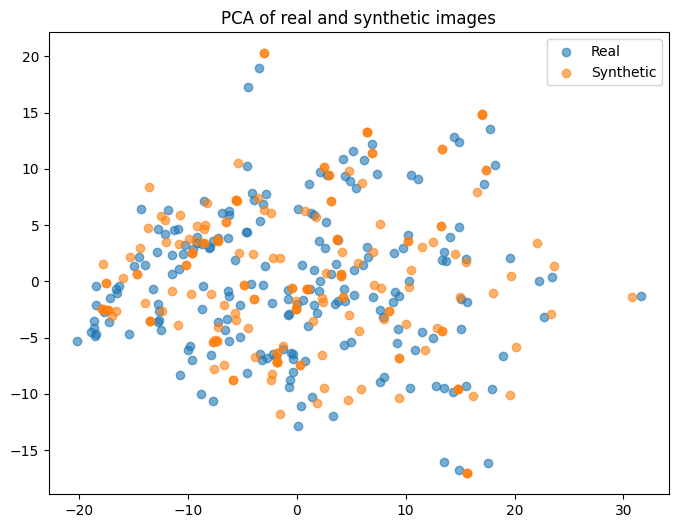

In [98]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

fake_images_scaled = np.array(fake_images_scaled)
real_images_scaled = np.array(real_images_scaled)

fake_images_scaled = fake_images_scaled.reshape(fake_images_scaled.shape[0], -1)
real_images_scaled = real_images_scaled.reshape(real_images_scaled.shape[0], -1)
# Combine datasets
X = np.vstack((fake_images_scaled, real_images_scaled))
y = np.array([0]*len(fake_images_scaled) + [1]*len(real_images_scaled))  # labels: 0=A, 1=B

pca = PCA(n_components=2)
X_embedded = pca.fit_transform(X)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_embedded[y==0, 0], X_embedded[y==0, 1], label="Real", alpha=0.6)
plt.scatter(X_embedded[y==1, 0], X_embedded[y==1, 1], label="Synthetic", alpha=0.6)
plt.legend()
plt.title("PCA of real and synthetic images")
plt.savefig("model_2_pca.pdf", bbox_inches='tight')
plt.show()

## VAE Model

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from tqdm import tqdm
import os

# ----------------------------
# Encoder
# ----------------------------
class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1)  # 64→32
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1) # 32→16
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1)# 16→8
        self.conv4 = nn.Conv2d(128, 256, 4, 2, 1)# 8→4
        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# ----------------------------
# Decoder
# ----------------------------
class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256*4*4)
        self.deconv1 = nn.ConvTranspose2d(256, 128, 4, 2, 1) # 4→8
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)  # 8→16
        self.deconv3 = nn.ConvTranspose2d(64, 32, 4, 2, 1)   # 16→32
        self.deconv4 = nn.ConvTranspose2d(32, 3, 4, 2, 1)    # 32→64
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 256, 4, 4)
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        x = self.tanh(self.deconv4(x))  # output in [-1,1]
        return x

# ----------------------------
# Beta-VAE
# ----------------------------
class BetaVAE(nn.Module):
    def __init__(self, latent_dim=128, beta=4.0):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.beta = beta

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

    def loss_function(self, recon, x, mu, logvar):
        # Reconstruction loss
        recon_loss = F.mse_loss(recon, x, reduction='sum') / x.size(0)
        # KL divergence
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        return recon_loss + self.beta * kl, recon_loss, kl


In [76]:
from torchinfo import summary
model = BetaVAE(latent_dim=128, beta=4.0).to(device)
summary(model, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
BetaVAE                                  [1, 3, 64, 64]            --
├─Encoder: 1-1                           [1, 128]                  --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           1,568
│    └─ReLU: 2-2                         [1, 32, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 64, 16, 16]           32,832
│    └─ReLU: 2-4                         [1, 64, 16, 16]           --
│    └─Conv2d: 2-5                       [1, 128, 8, 8]            131,200
│    └─ReLU: 2-6                         [1, 128, 8, 8]            --
│    └─Conv2d: 2-7                       [1, 256, 4, 4]            524,544
│    └─ReLU: 2-8                         [1, 256, 4, 4]            --
│    └─Linear: 2-9                       [1, 128]                  524,416
│    └─Linear: 2-10                      [1, 128]                  524,416
├─Decoder: 1-2                           [1, 3, 64, 64]   

Epoch 1/200: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch 0 , Loss:  39658.20947265625


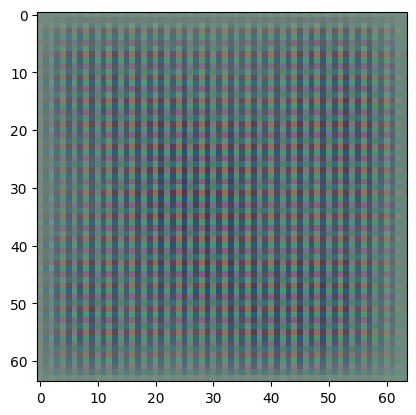

Epoch 2/200: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch 1 , Loss:  25019.2099609375


Epoch 3/200: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Epoch 2 , Loss:  16846.87255859375


Epoch 4/200: 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Epoch 3 , Loss:  14036.27978515625


Epoch 5/200: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Epoch 4 , Loss:  12442.808959960938


Epoch 6/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 5 , Loss:  11359.832885742188


Epoch 7/200: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Epoch 6 , Loss:  10910.394775390625


Epoch 8/200: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch 7 , Loss:  10603.392944335938


Epoch 9/200: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch 8 , Loss:  10398.501342773438


Epoch 10/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 9 , Loss:  10204.596435546875


Epoch 11/200: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch 10 , Loss:  10027.6962890625


Epoch 12/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 11 , Loss:  9991.958984375


Epoch 13/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 12 , Loss:  9820.07763671875


Epoch 14/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 13 , Loss:  9595.3251953125


Epoch 15/200: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 14 , Loss:  9529.286254882812


Epoch 16/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 15 , Loss:  9460.467895507812


Epoch 17/200: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Epoch 16 , Loss:  9435.867797851562


Epoch 18/200: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 17 , Loss:  9425.895263671875


Epoch 19/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 18 , Loss:  9309.945434570312


Epoch 20/200: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch 19 , Loss:  9324.434936523438


Epoch 21/200: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 20 , Loss:  9076.149658203125


Epoch 22/200: 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


Epoch 21 , Loss:  9105.310974121094


Epoch 23/200: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Epoch 22 , Loss:  9039.962158203125


Epoch 24/200: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Epoch 23 , Loss:  8987.378173828125


Epoch 25/200: 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]


Epoch 24 , Loss:  8888.3544921875


Epoch 26/200: 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]


Epoch 25 , Loss:  8785.133666992188


Epoch 27/200: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Epoch 26 , Loss:  8665.583435058594


Epoch 28/200: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Epoch 27 , Loss:  8600.86376953125


Epoch 29/200: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch 28 , Loss:  8529.59423828125


Epoch 30/200: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Epoch 29 , Loss:  8475.540588378906


Epoch 31/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 30 , Loss:  8434.2294921875


Epoch 32/200: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Epoch 31 , Loss:  8290.00439453125


Epoch 33/200: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 32 , Loss:  8233.001770019531


Epoch 34/200: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 33 , Loss:  8027.5299072265625


Epoch 35/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 34 , Loss:  7805.614440917969


Epoch 36/200: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 35 , Loss:  7673.665771484375


Epoch 37/200: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 36 , Loss:  7599.212829589844


Epoch 38/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 37 , Loss:  7438.915832519531


Epoch 39/200: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 38 , Loss:  7324.52783203125


Epoch 40/200: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 39 , Loss:  7235.913330078125


Epoch 41/200: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch 40 , Loss:  7097.7247314453125


Epoch 42/200: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch 41 , Loss:  7053.705749511719


Epoch 43/200: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Epoch 42 , Loss:  6919.2855224609375


Epoch 44/200: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Epoch 43 , Loss:  6840.456359863281


Epoch 45/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 44 , Loss:  6662.8363037109375


Epoch 46/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 45 , Loss:  6619.193664550781


Epoch 47/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 46 , Loss:  6495.515625


Epoch 48/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 47 , Loss:  6435.349914550781


Epoch 49/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 48 , Loss:  6348.9544677734375


Epoch 50/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 49 , Loss:  6220.506103515625


Epoch 51/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 50 , Loss:  6147.005798339844


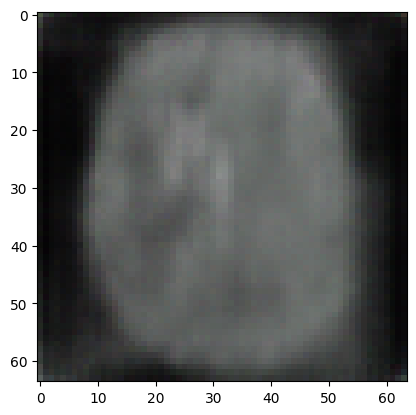

Epoch 52/200: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 51 , Loss:  6141.672912597656


Epoch 53/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 52 , Loss:  5972.3812255859375


Epoch 54/200: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch 53 , Loss:  5903.619079589844


Epoch 55/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 54 , Loss:  5891.7618408203125


Epoch 56/200: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Epoch 55 , Loss:  5808.424743652344


Epoch 57/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 56 , Loss:  5678.991455078125


Epoch 58/200: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 57 , Loss:  5587.25634765625


Epoch 59/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 58 , Loss:  5502.4178466796875


Epoch 60/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 59 , Loss:  5436.466857910156


Epoch 61/200: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 60 , Loss:  5347.476257324219


Epoch 62/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 61 , Loss:  5308.225891113281


Epoch 63/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 62 , Loss:  5253.7275390625


Epoch 64/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 63 , Loss:  5221.811340332031


Epoch 65/200: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 64 , Loss:  5146.127136230469


Epoch 66/200: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 65 , Loss:  5047.515869140625


Epoch 67/200: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 66 , Loss:  4953.789306640625


Epoch 68/200: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Epoch 67 , Loss:  4874.206604003906


Epoch 69/200: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 68 , Loss:  4792.943359375


Epoch 70/200: 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 69 , Loss:  4766.478210449219


Epoch 71/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 70 , Loss:  4732.494323730469


Epoch 72/200: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 71 , Loss:  4685.1571044921875


Epoch 73/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 72 , Loss:  4644.413391113281


Epoch 74/200: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 73 , Loss:  4521.153503417969


Epoch 75/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 74 , Loss:  4491.192321777344


Epoch 76/200: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 75 , Loss:  4439.724670410156


Epoch 77/200: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 76 , Loss:  4404.77099609375


Epoch 78/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 77 , Loss:  4389.86328125


Epoch 79/200: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 78 , Loss:  4310.59130859375


Epoch 80/200: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 79 , Loss:  4252.823944091797


Epoch 81/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 80 , Loss:  4198.885589599609


Epoch 82/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 81 , Loss:  4181.5860595703125


Epoch 83/200: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 82 , Loss:  4114.676483154297


Epoch 84/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 83 , Loss:  4075.210479736328


Epoch 85/200: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 84 , Loss:  4069.2322998046875


Epoch 86/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 85 , Loss:  4021.6907348632812


Epoch 87/200: 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 86 , Loss:  4001.6214904785156


Epoch 88/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 87 , Loss:  3985.723846435547


Epoch 89/200: 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 88 , Loss:  3964.699188232422


Epoch 90/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 89 , Loss:  3905.6045837402344


Epoch 91/200: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 90 , Loss:  3878.616180419922


Epoch 92/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 91 , Loss:  3790.0299682617188


Epoch 93/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 92 , Loss:  3771.042205810547


Epoch 94/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 93 , Loss:  3740.5985717773438


Epoch 95/200: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 94 , Loss:  3695.6830444335938


Epoch 96/200: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 95 , Loss:  3663.8723754882812


Epoch 97/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 96 , Loss:  3588.3429260253906


Epoch 98/200: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 97 , Loss:  3585.1204833984375


Epoch 99/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 98 , Loss:  3576.969268798828


Epoch 100/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 99 , Loss:  3532.8462524414062


Epoch 101/200: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 100 , Loss:  3495.8598022460938


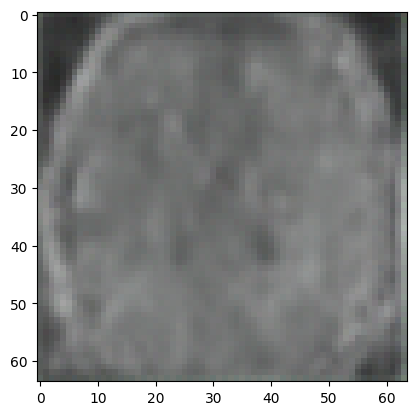

Epoch 102/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 101 , Loss:  3486.613006591797


Epoch 103/200: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 102 , Loss:  3445.339813232422


Epoch 104/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 103 , Loss:  3428.3102111816406


Epoch 105/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 104 , Loss:  3439.5112915039062


Epoch 106/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 105 , Loss:  3400.0047607421875


Epoch 107/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 106 , Loss:  3353.730438232422


Epoch 108/200: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 107 , Loss:  3359.654754638672


Epoch 109/200: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 108 , Loss:  3306.7132263183594


Epoch 110/200: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 109 , Loss:  3305.0330810546875


Epoch 111/200: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 110 , Loss:  3269.9280395507812


Epoch 112/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 111 , Loss:  3230.3457946777344


Epoch 113/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 112 , Loss:  3227.1829833984375


Epoch 114/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 113 , Loss:  3175.7470703125


Epoch 115/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 114 , Loss:  3129.238311767578


Epoch 116/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 115 , Loss:  3135.6281127929688


Epoch 117/200: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 116 , Loss:  3109.926055908203


Epoch 118/200: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 117 , Loss:  3094.0708618164062


Epoch 119/200: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 118 , Loss:  3076.795928955078


Epoch 120/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 119 , Loss:  3069.171905517578


Epoch 121/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 120 , Loss:  3026.13525390625


Epoch 122/200: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 121 , Loss:  3016.521026611328


Epoch 123/200: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Epoch 122 , Loss:  3004.2449340820312


Epoch 124/200: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Epoch 123 , Loss:  2996.2189331054688


Epoch 125/200: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Epoch 124 , Loss:  2977.3956909179688


Epoch 126/200: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Epoch 125 , Loss:  2945.6021118164062


Epoch 127/200: 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Epoch 126 , Loss:  2918.899444580078


Epoch 128/200: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Epoch 127 , Loss:  2916.310760498047


Epoch 129/200: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Epoch 128 , Loss:  2886.3094482421875


Epoch 130/200: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Epoch 129 , Loss:  2875.625274658203


Epoch 131/200: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Epoch 130 , Loss:  2864.1776123046875


Epoch 132/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 131 , Loss:  2846.8390502929688


Epoch 133/200: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Epoch 132 , Loss:  2814.5245971679688


Epoch 134/200: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 133 , Loss:  2781.2051696777344


Epoch 135/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 134 , Loss:  2781.2086486816406


Epoch 136/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 135 , Loss:  2798.937469482422


Epoch 137/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 136 , Loss:  2774.5006103515625


Epoch 138/200: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 137 , Loss:  2777.8805236816406


Epoch 139/200: 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 138 , Loss:  2734.9251403808594


Epoch 140/200: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 139 , Loss:  2739.9901733398438


Epoch 141/200: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 140 , Loss:  2713.119903564453


Epoch 142/200: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 141 , Loss:  2677.6220703125


Epoch 143/200: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 142 , Loss:  2637.2462158203125


Epoch 144/200: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Epoch 143 , Loss:  2680.550079345703


Epoch 145/200: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 144 , Loss:  2652.6958923339844


Epoch 146/200: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Epoch 145 , Loss:  2620.6548461914062


Epoch 147/200: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Epoch 146 , Loss:  2604.4014282226562


Epoch 148/200: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Epoch 147 , Loss:  2578.8863525390625


Epoch 149/200: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 148 , Loss:  2577.056121826172


Epoch 150/200: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Epoch 149 , Loss:  2576.2308654785156


Epoch 151/200: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Epoch 150 , Loss:  2585.843048095703


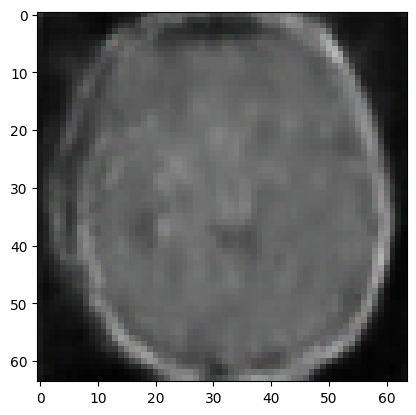

Epoch 152/200: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 151 , Loss:  2558.874481201172


Epoch 153/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 152 , Loss:  2537.9261474609375


Epoch 154/200: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 153 , Loss:  2521.0158081054688


Epoch 155/200: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch 154 , Loss:  2511.4859619140625


Epoch 156/200: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 155 , Loss:  2494.9576721191406


Epoch 157/200: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Epoch 156 , Loss:  2480.3885498046875


Epoch 158/200: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 157 , Loss:  2477.584197998047


Epoch 159/200: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Epoch 158 , Loss:  2476.426727294922


Epoch 160/200: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Epoch 159 , Loss:  2458.7789001464844


Epoch 161/200: 100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


Epoch 160 , Loss:  2440.4693603515625


Epoch 162/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 161 , Loss:  2433.5958862304688


Epoch 163/200: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 162 , Loss:  2413.3848571777344


Epoch 164/200: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 163 , Loss:  2399.5885620117188


Epoch 165/200: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 164 , Loss:  2424.4143676757812


Epoch 166/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 165 , Loss:  2429.035919189453


Epoch 167/200: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 166 , Loss:  2419.432861328125


Epoch 168/200: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch 167 , Loss:  2411.3340454101562


Epoch 169/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 168 , Loss:  2394.4418029785156


Epoch 170/200: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 169 , Loss:  2379.338623046875


Epoch 171/200: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Epoch 170 , Loss:  2360.7920532226562


Epoch 172/200: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch 171 , Loss:  2352.2569580078125


Epoch 173/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 172 , Loss:  2319.7581176757812


Epoch 174/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 173 , Loss:  2330.697998046875


Epoch 175/200: 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Epoch 174 , Loss:  2320.41259765625


Epoch 176/200: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Epoch 175 , Loss:  2353.228790283203


Epoch 177/200: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch 176 , Loss:  2296.0437927246094


Epoch 178/200: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Epoch 177 , Loss:  2294.9857788085938


Epoch 179/200: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Epoch 178 , Loss:  2278.7720947265625


Epoch 180/200: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch 179 , Loss:  2271.159423828125


Epoch 181/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 180 , Loss:  2274.8780212402344


Epoch 182/200: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Epoch 181 , Loss:  2282.8058471679688


Epoch 183/200: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Epoch 182 , Loss:  2270.5524291992188


Epoch 184/200: 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Epoch 183 , Loss:  2243.7463989257812


Epoch 185/200: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 184 , Loss:  2207.7518310546875


Epoch 186/200: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 185 , Loss:  2213.1112670898438


Epoch 187/200: 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Epoch 186 , Loss:  2177.0870056152344


Epoch 188/200: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 187 , Loss:  2175.6376342773438


Epoch 189/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 188 , Loss:  2192.873992919922


Epoch 190/200: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 189 , Loss:  2173.9835205078125


Epoch 191/200: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 190 , Loss:  2169.8421936035156


Epoch 192/200: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 191 , Loss:  2166.4998474121094


Epoch 193/200: 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 192 , Loss:  2174.043975830078


Epoch 194/200: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Epoch 193 , Loss:  2173.31884765625


Epoch 195/200: 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Epoch 194 , Loss:  2161.888397216797


Epoch 196/200: 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Epoch 195 , Loss:  2140.5357360839844


Epoch 197/200: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Epoch 196 , Loss:  2119.436737060547


Epoch 198/200: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Epoch 197 , Loss:  2114.4734954833984


Epoch 199/200: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Epoch 198 , Loss:  2112.6363830566406


Epoch 200/200: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]

Epoch 199 , Loss:  2107.9813385009766


In [77]:
model = BetaVAE(latent_dim=128, beta=4.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs=200
for epoch in range(epochs):
    run_loss = 0
    
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    for imgs, _ in loop:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(imgs)
        loss, recon_loss, kl = model.loss_function(recon, imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
            
    print("Epoch", epoch, ", Loss: ", run_loss)
    if epoch%50 == 0:
        with torch.no_grad():
            #sample_imgs = imgs[:8]
            sample_from_latent = torch.randn(64, 128).to(device)
            fake = model.decoder(sample_from_latent.to(device))
        img = fake[0].cpu().permute(1, 2, 0).numpy()
        img = (img + 1) / 2.0
        plt.imshow(img)
        plt.show()

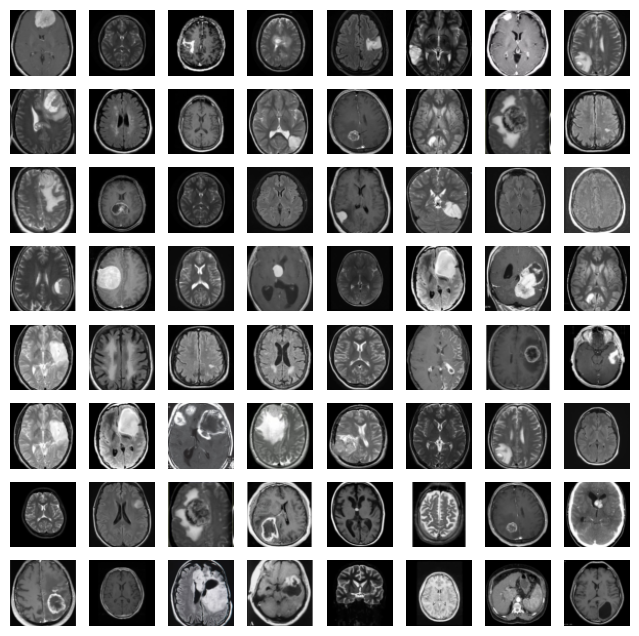

In [99]:
# real images
fig, axes = plt.subplots(8, 8, figsize=(8, 8))

real_images_scaled = []
for i, ax in enumerate(axes.flat):
    img = batch1[0][i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    real_images_scaled.append(img)
    ax.imshow(img)
    ax.axis("off")

real_images = next(iter(dataloader))
for i in range(64):
    img = batch2[0][i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    real_images_scaled.append(img)

real_images = next(iter(dataloader))
for i in range(64):
    img = batch3[0][i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    real_images_scaled.append(img)

fig.savefig("model_3_images.pdf", bbox_inches='tight')
plt.show()

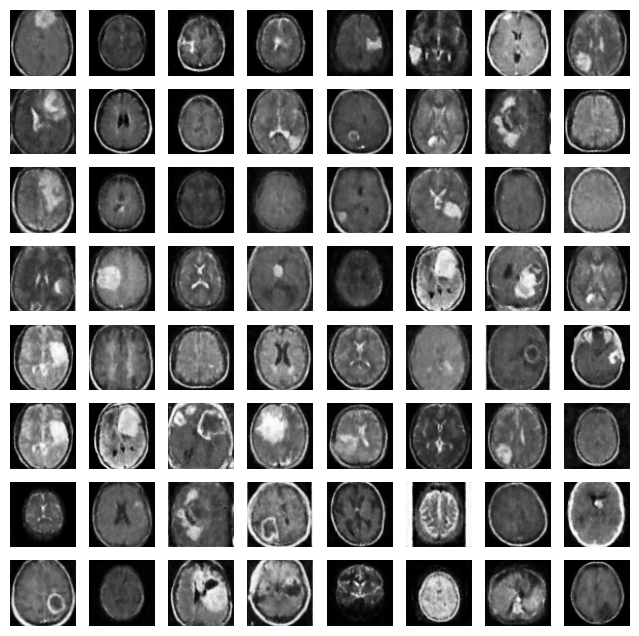

In [100]:
# fake images from original image at inference
with torch.no_grad():
    sample_imgs = batch1[0][:64]
    fake = model(sample_imgs.to(device))[0].detach().cpu()

fig, axes = plt.subplots(8, 8, figsize=(8, 8))

fake_images_scaled = []
for i, ax in enumerate(axes.flat):
    img = fake[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    fake_images_scaled.append(img)
    ax.imshow(img)
    ax.axis("off")

real_images = next(iter(dataloader))
with torch.no_grad():
    sample_imgs = batch2[0][:64]
    fake = model(sample_imgs.to(device))[0].detach().cpu()

for i in range(64):
    img = fake[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    fake_images_scaled.append(img)


real_images = next(iter(dataloader))
with torch.no_grad():
    sample_imgs = batch3[0][:64]
    fake = model(sample_imgs.to(device))[0].detach().cpu()
for i in range(64):
    img = fake[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    fake_images_scaled.append(img)

fig.savefig("model_3_fake.pdf", bbox_inches='tight')
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


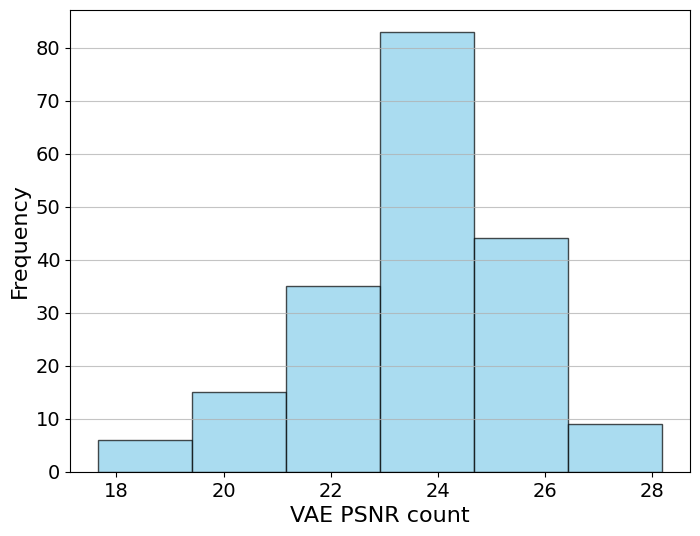

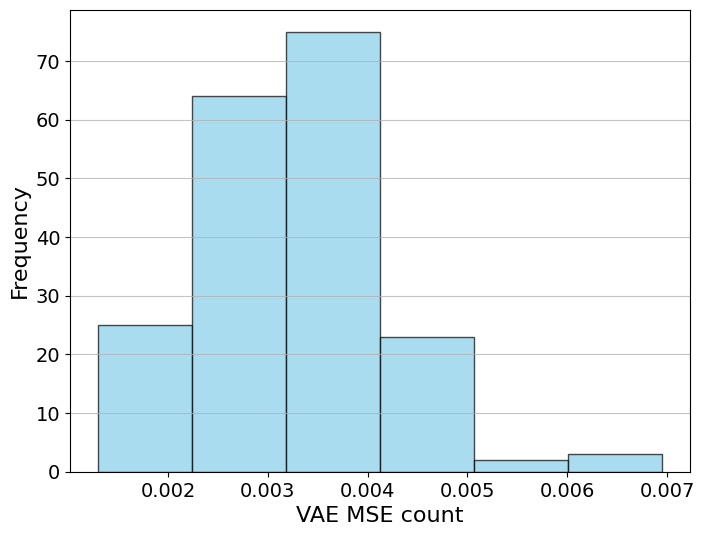

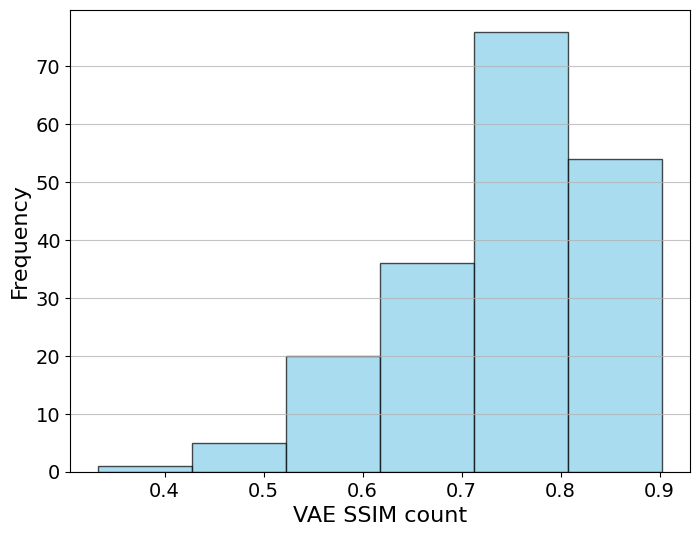

In [80]:
from tqdm import tqdm
fake_images_scaled = np.array(fake_images_scaled)
real_images_scaled = np.array(real_images_scaled)

compare = ImageSimilarity()

psnr_count = []
for fake_img, real_img in zip(fake_images_scaled, real_images_scaled):
    psnr_count.append(compare.psnr(real_img, fake_img))

mse_count = []
for fake_img, real_img in zip(fake_images_scaled, real_images_scaled):
    mse_count.append(compare.mse(real_img, fake_img))

ssim_score_count = []
for fake_img, real_img in zip(fake_images_scaled, real_images_scaled):
    ssim_score_count.append(compare.ssim_score(real_img, fake_img))


import matplotlib.pyplot as plt

plot_hist(psnr_count, what2plot="VAE PSNR count")
plot_hist(mse_count, what2plot="VAE MSE count")
plot_hist(ssim_score_count, what2plot="VAE SSIM count")

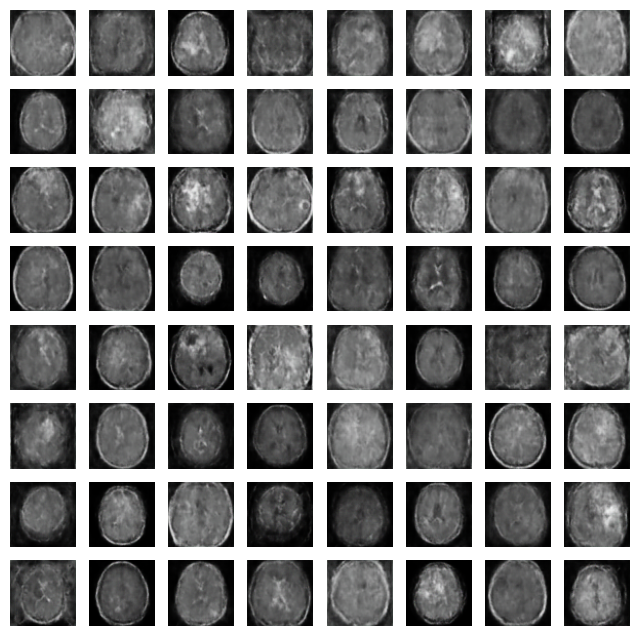

In [81]:
# fake images from random sampling at inference
with torch.no_grad():
    sample_from_latent = torch.randn(64, 128).to(device)
    fake = model.decoder(sample_from_latent.to(device)).detach().cpu()
    #fake = model(sample_imgs.to(device))[0].detach().cpu()

fig, axes = plt.subplots(8, 8, figsize=(8, 8))

fake_images_scaled = []
for i, ax in enumerate(axes.flat):
    img = fake[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    fake_images_scaled.append(img)
    ax.imshow(img)
    ax.axis("off")

real_images = next(iter(dataloader))
with torch.no_grad():
    sample_from_latent = torch.randn(64, 128).to(device)
    fake = model.decoder(sample_from_latent.to(device)).detach().cpu()

for i in range(64):
    img = fake[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    fake_images_scaled.append(img)


real_images = next(iter(dataloader))
with torch.no_grad():
    sample_from_latent = torch.randn(64, 128).to(device)
    fake = model.decoder(sample_from_latent.to(device)).detach().cpu()
for i in range(64):
    img = fake[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2.0
    fake_images_scaled.append(img)

fig.savefig("model_3_noisy_fake.pdf", bbox_inches='tight')

plt.show()

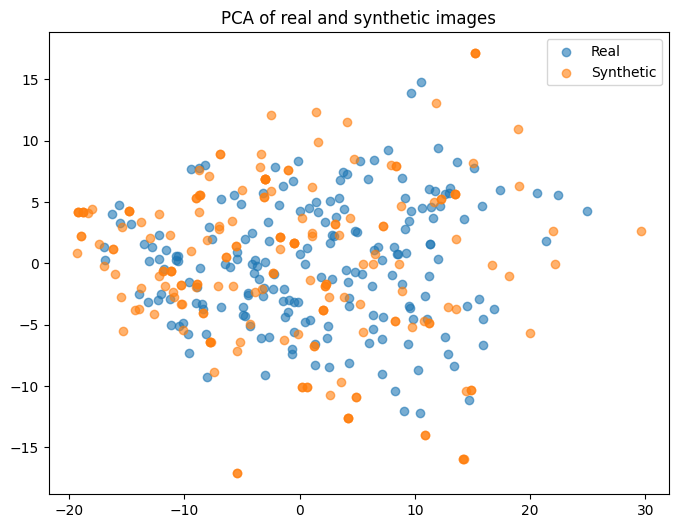

In [82]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

fake_images_scaled = np.array(fake_images_scaled)
real_images_scaled = np.array(real_images_scaled)

fake_images_scaled = fake_images_scaled.reshape(fake_images_scaled.shape[0], -1)
real_images_scaled = real_images_scaled.reshape(real_images_scaled.shape[0], -1)

X = np.vstack((fake_images_scaled, real_images_scaled))
y = np.array([0]*len(fake_images_scaled) + [1]*len(real_images_scaled))  # labels: 0=A, 1=B

pca = PCA(n_components=2)
X_embedded = pca.fit_transform(X)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_embedded[y==0, 0], X_embedded[y==0, 1], label="Real", alpha=0.6)
plt.scatter(X_embedded[y==1, 0], X_embedded[y==1, 1], label="Synthetic", alpha=0.6)
plt.legend()
plt.title("PCA of real and synthetic images")
plt.savefig("model_3_pca.pdf", bbox_inches='tight')
plt.show()